# Import Libraries


In [1]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np 


from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from wordcloud import WordCloud,STOPWORDS
import spacy 
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC



import warnings
warnings.filterwarnings('ignore')



In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load Data

In [3]:
id = '1bSGHGu55SeHcwK7YYfohDNi1lMq0BDzI' # The shareable link
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Hotel_Reviews.csv')  
raw_df = pd.read_csv('Hotel_Reviews.csv')

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [5]:
# Convert reviewer scores to 0, 1-> 0 for negative, 1 for positive

#check column min and max
raw_df['Reviewer_Score'].describe()

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64

In [6]:
raw_df['Reviewer_Score'] = raw_df['Reviewer_Score'].round()


In [7]:
raw_df['Reviewer_Score'].value_counts()

10.0    187744
8.0     110155
9.0     105722
7.0      44088
6.0      27800
5.0      24188
4.0       9436
3.0       4406
2.0       2199
Name: Reviewer_Score, dtype: int64

In [8]:
neg = range(6)


def sentiment(rating):
    if rating in neg:
        return 0
    else:
        return 1


In [9]:
raw_df['sentiments'] = raw_df['Reviewer_Score'].apply(sentiment)
raw_df['sentiments'].value_counts()
#print(raw_df.loc[raw_df['score'] == 0])

1    475509
0     40229
Name: sentiments, dtype: int64

# Combining Positive and Negative reviews into 1 column

In [10]:
pos_reviews = (raw_df['Positive_Review']!='No Positive').sum()
neg_reviews = (raw_df['Negative_Review']!='No Negative').sum()

In [11]:
#replacing "no positive" and "no negative" reviews from both columns
(raw_df['Positive_Review']=='No Positive').sum()

35946

In [12]:
(raw_df['Negative_Review']=='No Negative').sum()

127890

In [13]:
(raw_df['Negative_Review']==' No negatives').sum()

47

In [14]:
# # overwriting column with No negative/ No positive with ""
raw_df['Positive_Review']= raw_df['Positive_Review'].replace('No Positive', "")
raw_df['Negative_Review']= raw_df['Negative_Review'].replace('No Negative', "")
raw_df['Negative_Review']= raw_df['Negative_Review'].replace(' No negatives', "") 

In [15]:
# Concatenating the positve review and negative review
raw_df['reviews'] = raw_df[['Positive_Review', 'Negative_Review']].apply(lambda x: ' '.join(x), axis = 1)

print(raw_df.loc[1327, 'reviews'])

 very confy bed Great bar with lovely staff   I just don t think a room without breakfast is worth 269 I suppose the problem is that if people will pay it you can charge it 


# Work the text

Remove StopWords, Punctuation, Lemmatize etc.

* lower text
* tokenize and remove punctuation
* remove empty tokens
* remove words that contain numbers
* remove stop words
* remove words with a letter
* pos tag text
* lematize text



Clean text.

In [16]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    #customize extra stop_words
    new_stopwords = ["hotel","room","everything","anything","nothing","thing","need",
                        "good","great","excellent","perfect","much","even","really","stay","could","would",
                        "well","make","also","one"]  
    stop.extend(new_stopwords)
    text = [x for x in text if x not in stop]
    # remove words with more than two letter
    text = [t for t in text if len(t) > 2]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # join all
    text = " ".join(text)
    return(text)



In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:

nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [22]:
%%time
# clean text data
raw_df['c_review'] = raw_df['reviews'].apply(clean_text)

CPU times: user 13min 38s, sys: 17 s, total: 13min 55s
Wall time: 13min 57s


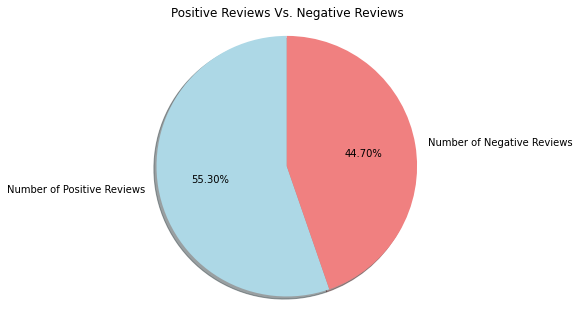

In [23]:
# Split of score reviews
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = [pos_reviews, neg_reviews]

ax.pie(values, 
       labels = ['Number of Positive Reviews', 'Number of Negative Reviews'],
       colors=['lightblue', 'lightcoral'],
       shadow=True,
       startangle=90, 
       autopct='%1.2f%%')
ax.axis('equal')
plt.title('Positive Reviews Vs. Negative Reviews');

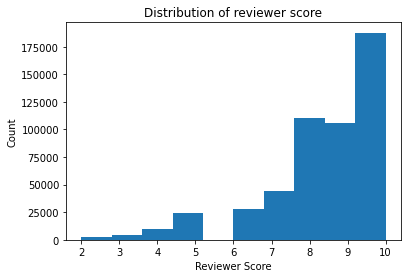

In [24]:
raw_df['Reviewer_Score'].plot.hist()
plt.title('Distribution of reviewer score')
plt.xlabel('Reviewer Score')
plt.ylabel('Count')
plt.show()

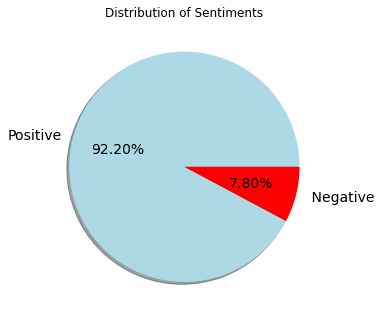

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = raw_df['sentiments'].value_counts()

ax.pie(values, 
       labels = ['Positive', ' Negative'],
       colors=['lightblue','red'],
       shadow=True, 
       autopct='%1.2f%%',
       textprops={'fontsize': 14})
plt.title('Distribution of Sentiments');


# Word Freq

In [35]:
# function to plot most frequent terms
def frequent_words(x, terms = 10):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(fontsize=15)
    plt.show()

## Positive

In [27]:
raw_df['Positive_Review'] = raw_df['Positive_Review'].apply(clean_text)

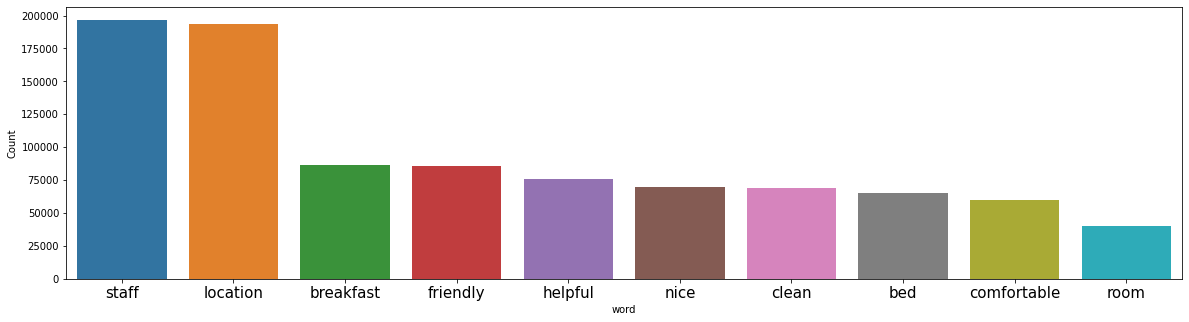

In [36]:
frequent_words(raw_df['Positive_Review'])

## Negative

In [29]:
raw_df['Negative_Review'] = raw_df['Negative_Review'].apply(clean_text)

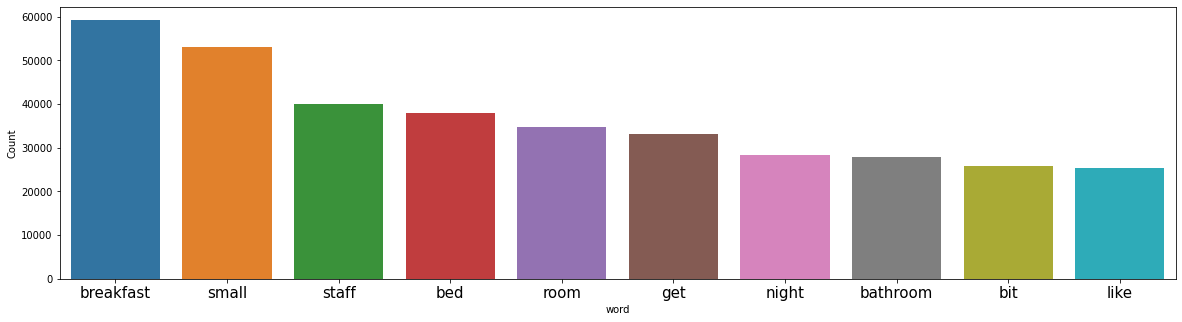

In [37]:
frequent_words(raw_df['Negative_Review'])